In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: Fetch the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_Korean_dramas"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Step 2: Extract data from unordered lists
data = []
sections = soup.find_all('div', {'class': 'mw-parser-output'})

for section in sections:
    lists = section.find_all('ul')  # Find all unordered lists in the content
    for ul in lists:
        list_items = ul.find_all('li')  # Find all list items within the unordered list
        for li in list_items:
            try:
                # Extract the text of each list item
                text = li.get_text(strip=True)
                # Split by parentheses to separate the title and the year
                if '(' in text:
                    title, year = text.rsplit('(', 1)
                    year = year.strip(')')
                else:
                    title, year = text, "Unknown"

                # Add data to the list
                data.append({
                    'Title': title.strip(),
                    'Year': year.strip()
                })
            except Exception as e:
                print(f"Error processing list item: {e}")

# Step 3: Save to CSV
if data:
    df = pd.DataFrame(data)
    csv_file = "korean_dramas_list.csv"
    df.to_csv(csv_file, index=False)
    print(f"KDrama data has been saved to {csv_file}")
else:
    print("No data extracted. Please check the page structure or script logic.")


KDrama data has been saved to korean_dramas_list.csv


In [ ]:
# Step 2: Filter dramas released in 2019
df_2019 = df[df['Year'] == '2019']  # Ensure the Year column is treated as a string

# Step 3: Save the filtered data to a new CSV file
output_file = "korean_dramas_2019.csv"
df_2019.to_csv(output_file, index=False)

print(f"Dramas from 2019 have been saved to {output_file}")

Dramas from 2019 have been saved to korean_dramas_2019.csv


In [ ]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14346 sha256=76b081bc7e3dbc4235be2f1e700cc5d9c8f9343df71885060b75d39015c90178
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [ ]:
import pandas as pd
import wikipediaapi
import re

# Step 1: Load the 2019 Dramas Data
df = pd.read_csv(csv_file)

# Initialize Wikipedia API with a User-Agent
wiki_wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent="KDramaScraper (bd567@scarletmail.rutgers.edu)"  # Replace with your app name and email
)

# Function to fetch genre, plot, and cast from Wikipedia
def fetch_wikipedia_info(title):
    try:
        # Fetch the Wikipedia page
        page = wiki_wiki.page(title)
        if not page.exists():
            return {"Genre": "N/A", "Plot": "N/A", "Cast": "N/A", "Rating": "N/A"}

        # Extract relevant sections
        text = page.text

        # Genre: Use regex to search for common patterns
        genre_match = re.search(r"(?i)genre.*?: (.+)", text)
        genre = genre_match.group(1) if genre_match else "N/A"

        # Plot: Extract the first paragraph
        plot = page.summary if page.summary else "N/A"

        # Cast: Use regex to extract the cast section
        cast_match = re.search(r"(?i)starring.*?: (.+)", text)
        cast = cast_match.group(1) if cast_match else "N/A"

        # Rating (if applicable from the page)
        rating_match = re.search(r"(?i)rating.*?: (.+)", text)
        rating = rating_match.group(1) if rating_match else "N/A"

        return {"Genre": genre.strip(), "Plot": plot.strip(), "Cast": cast.strip(), "Rating": rating.strip()}
    except Exception as e:
        print(f"Error fetching data for {title}: {e}")
        return {"Genre": "N/A", "Plot": "N/A", "Cast": "N/A", "Rating": "N/A"}

# Step 2: Iterate through the dramas and fetch additional information
info_list = []
for index, row in df.iterrows():
    title = row['Title']
    print(f"Fetching info for: {title}")
    info = fetch_wikipedia_info(title)
    info_list.append(info)

# Step 3: Add the fetched information to the DataFrame
additional_info_df = pd.DataFrame(info_list)
df = pd.concat([df, additional_info_df], axis=1)

# Step 4: Save the updated DataFrame to a new CSV file
output_file = "korean_dramas_2019_detailed.csv"
df.to_csv(output_file, index=False)
print(f"Detailed information has been saved to {output_file}")


Fetching info for: A-Teen 2
Fetching info for: Abyss
Fetching info for: Angel's Last Mission: Love
Fetching info for: Anniversary Anyway
Fetching info for: At Eighteen
Fetching info for: Babel
Fetching info for: Be Melodramatic
Fetching info for: Beautiful World
Fetching info for: Best Chicken
Fetching info for: Big Issue
Fetching info for: Birthday Letter
Fetching info for: Blessing of the Sea
Fetching info for: Catch the Ghost
Fetching info for: Chief of Staff
Fetching info for: Class of Lies
Fetching info for: Confession
Fetching info for: Designated Survivor: 60 Days
Fetching info for: Different Dreams
Fetching info for: Doctor Detective
Fetching info for: Doctor John
Fetching info for: Doctor Prisoner
Fetching info for: Extraordinary You
Fetching info for: Flower Crew: Joseon Marriage Agency
Fetching info for: Graceful Family
Fetching info for: Haechi
Fetching info for: He Is Psychometric
Fetching info for: Hell Is Other People
Fetching info for: Her Private Life
Fetching info for

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# Step 1: Load the Korean Dramas Data
df = pd.read_csv("/content/korean_dramas_list.csv")

# Wikipedia Search URL
search_url = "https://en.wikipedia.org/wiki/Special:Search"

# Step 2: Function to Search for Wikipedia Page
def search_wikipedia(title):
    try:
        params = {"search": title, "go": "Go"}
        response = requests.get(search_url, params=params)
        if response.status_code == 200:
            return response.url  # Return the resulting page URL
        else:
            print(f"Search failed for {title}")
            return None
    except Exception as e:
        print(f"Error searching for {title}: {e}")
        return None

# Step 3: Function to Fetch Details from Wikipedia Page
def fetch_drama_details(title, url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Initialize default values
        genre = "N/A"
        cast = "N/A"
        rating = "N/A"
        plot = "N/A"

        # Extract data from the infobox if it exists
        infobox = soup.find('table', {'class': 'infobox'})
        if infobox:
            for row in infobox.find_all('tr'):
                header = row.find('th')
                value = row.find('td')
                if header and value:
                    header_text = header.get_text(strip=True).lower()
                    value_text = value.get_text(strip=True, separator=', ')

                    if "genre" in header_text:
                        genre = value_text
                    elif "starring" in header_text or "cast" in header_text:
                        cast = value_text
                    elif "rating" in header_text:
                        rating = value_text

        # Extract plot (first paragraph in the main content)
        paragraphs = soup.find_all('p')
        for paragraph in paragraphs:
            if paragraph.get_text(strip=True):
                plot = paragraph.get_text(strip=True)
                break

        return {"Genre": genre, "Plot": plot, "Cast": cast, "Rating": rating}

    except Exception as e:
        print(f"Error fetching details for {title}: {e}")
        return {"Genre": "N/A", "Plot": "N/A", "Cast": "N/A", "Rating": "N/A"}

# Step 4: Search and Scrape for Each Drama
detailed_data = []
for index, row in df.iterrows():
    title = row['Title']
    print(f"Searching and fetching details for: {title} ({index + 1}/{len(df)})")

    # Step 4.1: Search for the Wikipedia Page
    url = search_wikipedia(title)
    if not url:
        print(f"Skipping {title}: No Wikipedia page found.")
        detailed_data.append({"Title": title, "Genre": "N/A", "Plot": "N/A", "Cast": "N/A", "Rating": "N/A"})
        continue

    # Step 4.2: Fetch Details from the Wikipedia Page
    details = fetch_drama_details(title, url)
    detailed_data.append({
        "Title": title,
        "Genre": details['Genre'],
        "Plot": details['Plot'],
        "Cast": details['Cast'],
        "Rating": details['Rating']
    })

    # Add delay to prevent overwhelming the server
    time.sleep(1)

# Step 5: Save the Updated Data to a New CSV File
detailed_df = pd.DataFrame(detailed_data)
output_file = "korean_dramas_complete_data.csv"
detailed_df.to_csv(output_file, index=False)
print(f"Detailed KDrama data saved to {output_file}")


Searching and fetching details for: 100 Days My Prince (1/1803)
Searching and fetching details for: 12 Signs of Love (2/1803)
Searching and fetching details for: 12 Years Promise (3/1803)
Searching and fetching details for: 18 Again (4/1803)
Searching and fetching details for: 1st Republic (5/1803)
Searching and fetching details for: 365: Repeat the Year (6/1803)
Searching and fetching details for: 4 Legendary Witches (7/1803)
Searching and fetching details for: 49 Days (8/1803)
Searching and fetching details for: 5th Republic (9/1803)
Searching and fetching details for: 7 First Kisses (10/1803)
Searching and fetching details for: 7th Grade Civil Servant (11/1803)
Searching and fetching details for: 90 Days, Time to Love (12/1803)
Searching and fetching details for: A Beautiful Mind (13/1803)
Searching and fetching details for: A Bird That Doesn't Sing (14/1803)
Searching and fetching details for: A Bloody Lucky Day (15/1803)
Searching and fetching details for: A Daughter Just Like You

In [ ]:
df = pd.read_csv("/content/korean_dramas_complete_data.csv")

# Check for missing or NA values in the "Cast" column
na_cast_count = df['Cast'].isna().sum()  # Count rows where "Cast" is NaN

# Optionally, include empty strings or 'N/A' explicitly
na_cast_count += df['Cast'].isin(['N/A', '']).sum()

print(f"Number of rows with missing 'Cast' values: {na_cast_count}")


NameError: name 'pd' is not defined

In [ ]:
df = pd.read_csv("/content/korean_dramas_complete_data.csv")

# Check for missing or NA values in the "Cast" column
na_cast_count = df['Genre'].isna().sum()  # Count rows where "Cast" is NaN

# Optionally, include empty strings or 'N/A' explicitly
na_cast_count += df['Genre'].isin(['N/A', '']).sum()

print(f"Number of rows with missing 'Genre' values: {na_cast_count}")

Number of rows with missing 'Genre' values: 601


In [ ]:
# Check for missing or NA values in both "Cast" and "Genre" columns
missing_rows = df[(df['Cast'].isna() | (df['Cast'] == 'N/A') | (df['Cast'] == '')) &
                  (df['Genre'].isna() | (df['Genre'] == 'N/A') | (df['Genre'] == ''))]

# Count the rows
missing_count = missing_rows.shape[0]

print(f"Number of rows where both 'Cast' and 'Genre' are missing: {missing_count}")

# Optional: Display these rows
print(missing_rows)

Number of rows where both 'Cast' and 'Genre' are missing: 536
                     Title Genre  \
4             1st Republic   NaN   
8             5th Republic   NaN   
12        A Beautiful Mind   NaN   
28              A New Leaf   NaN   
30      A Place in the Sun   NaN   
...                    ...   ...   
1782    You Are My Destiny   NaN   
1783    You Are My Destiny   NaN   
1787  You Are the Only One   NaN   
1795            Your Honor   NaN   
1796            Your Honor   NaN   

                                                   Plot Cast Rating  
4                           First Republicmay refer to:  NaN    NaN  
8                           Fifth Republicmay refer to:  NaN    NaN  
12                        A Beautiful Mindmay refer to:  NaN    NaN  
28                    A New LeaforNew Leafmay refer to:  NaN    NaN  
30                      A Place in the Sunmay refer to:  NaN    NaN  
...                                                 ...  ...    ...  
1782  You Are M

In [ ]:
import pandas as pd
#import user watched kdramas
watched_kdramas = pd.read_csv("/content/Watched_KDramas_Expanded.csv")
watched_kdramas.head()

,Title,Genre(s),Description
0,Itaewon Class,"Drama, Business, Romance",A revenge-driven young entrepreneur takes on s...
1,Hotel Del Luna,"Fantasy, Romance, Comedy",A hotel for ghosts with a mysterious CEO and a...
2,Goblin (Guardian),"Fantasy, Romance, Drama",An immortal goblin seeks to end his cursed imm...
3,The Legend of the Blue Sea,"Fantasy, Romance, Comedy",A mermaid from the Joseon era tries to adapt t...
4,Strong Woman Do Bong Soon,"Comedy, Romance, Action",A young woman with superhuman strength gets en...


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# Step 1: Load the Korean Dramas Data
df = pd.read_csv("/content/Watched_KDramas_Expanded.csv")

# Wikipedia Search URL
search_url = "https://en.wikipedia.org/wiki/Special:Search"

# Step 2: Function to Search for Wikipedia Page
def search_wikipedia(title):
    try:
        params = {"search": title, "go": "Go"}
        response = requests.get(search_url, params=params)
        if response.status_code == 200:
            return response.url  # Return the resulting page URL
        else:
            print(f"Search failed for {title}")
            return None
    except Exception as e:
        print(f"Error searching for {title}: {e}")
        return None

# Step 3: Function to Fetch Details from Wikipedia Page
def fetch_drama_details(title, url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Initialize default values
        genre = "N/A"
        cast = "N/A"
        rating = "N/A"
        plot = "N/A"

        # Extract data from the infobox if it exists
        infobox = soup.find('table', {'class': 'infobox'})
        if infobox:
            for row in infobox.find_all('tr'):
                header = row.find('th')
                value = row.find('td')
                if header and value:
                    header_text = header.get_text(strip=True).lower()
                    value_text = value.get_text(strip=True, separator=', ')

                    if "genre" in header_text:
                        genre = value_text
                    elif "starring" in header_text or "cast" in header_text:
                        cast = value_text
                    elif "rating" in header_text:
                        rating = value_text

        # Extract plot (first paragraph in the main content)
        paragraphs = soup.find_all('p')
        for paragraph in paragraphs:
            if paragraph.get_text(strip=True):
                plot = paragraph.get_text(strip=True)
                break

        return {"Genre": genre, "Plot": plot, "Cast": cast, "Rating": rating}

    except Exception as e:
        print(f"Error fetching details for {title}: {e}")
        return {"Genre": "N/A", "Plot": "N/A", "Cast": "N/A", "Rating": "N/A"}

# Step 4: Search and Scrape for Each Drama
detailed_data = []
for index, row in df.iterrows():
    title = row['Title']
    print(f"Searching and fetching details for: {title} ({index + 1}/{len(df)})")

    # Step 4.1: Search for the Wikipedia Page
    url = search_wikipedia(title)
    if not url:
        print(f"Skipping {title}: No Wikipedia page found.")
        detailed_data.append({"Title": title, "Genre": "N/A", "Plot": "N/A", "Cast": "N/A", "Rating": "N/A"})
        continue

    # Step 4.2: Fetch Details from the Wikipedia Page
    details = fetch_drama_details(title, url)
    detailed_data.append({
        "Title": title,
        "Genre": details['Genre'],
        "Plot": details['Plot'],
        "Cast": details['Cast'],
        "Rating": details['Rating']
    })

    # Add delay to prevent overwhelming the server
    time.sleep(1)

# Step 5: Save the Updated Data to a New CSV File
detailed_df = pd.DataFrame(detailed_data)
output_file = "watched_kdramas_complete_data.csv"
detailed_df.to_csv(output_file, index=False)
print(f"Detailed Watched KDrama data saved to {output_file}")


Searching and fetching details for: Itaewon Class (1/49)
Searching and fetching details for: Hotel Del Luna (2/49)
Searching and fetching details for: Goblin (Guardian) (3/49)
Searching and fetching details for: The Legend of the Blue Sea (4/49)
Searching and fetching details for: Strong Woman Do Bong Soon (5/49)
Searching and fetching details for: Vincenzo (6/49)
Searching and fetching details for: Pinocchio (7/49)
Searching and fetching details for: Fight For My Way (8/49)
Searching and fetching details for: True Beauty (9/49)
Searching and fetching details for: Weightlifting Fairy Kim Bok-joo (10/49)
Searching and fetching details for: Boys Over Flowers (11/49)
Searching and fetching details for: Extraordinary You (12/49)
Searching and fetching details for: Doctor Stranger (13/49)
Searching and fetching details for: While You Were Sleeping (14/49)
Searching and fetching details for: Moon Lovers: Scarlet Heart Ryeo (15/49)
Searching and fetching details for: The King: Eternal Monarch

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load datasets
watched_kdramas = pd.read_csv("/content/Watched_KDramas_Expanded.csv")
all_kdramas = pd.read_csv("/content/korean_dramas_complete_data.csv")

# Clean data: Handle missing values
all_kdramas.dropna(subset=['Title', 'Genre', 'Cast'], inplace=True)

# Normalize text fields for case-insensitivity
watched_kdramas['Title'] = watched_kdramas['Title'].str.lower()
all_kdramas['Title'] = all_kdramas['Title'].str.lower()
all_kdramas['Genre'] = all_kdramas['Genre'].str.lower()

# Combine features for recommendation
def combine_features(row):
    return f"{row['Genre']} {row['Cast']}"

all_kdramas['Combined'] = all_kdramas.apply(combine_features, axis=1)

# TF-IDF setup
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(all_kdramas['Combined'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend based on watched dramas
def recommend_based_on_drama(watched_titles):
    watched_indices = all_kdramas[all_kdramas['Title'].isin(watched_titles)].index
    recommendations = []
    for idx in watched_indices:
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        recommendations.extend([all_kdramas.iloc[i[0]]['Title'] for i in sim_scores[1:]])
    recommendations = [rec for rec in recommendations if rec not in watched_titles]
    return list(dict.fromkeys(recommendations))[:10]

# Function to recommend based on genre
def recommend_based_on_genre(preferred_genre):
    preferred_genre = preferred_genre.lower()
    all_kdramas['Genre_Match'] = all_kdramas['Genre'].apply(lambda x: preferred_genre in x)
    genre_kdramas = all_kdramas[all_kdramas['Genre_Match']]
    return genre_kdramas['Title'].tolist()[:10]

# Interactive Widgets
def display_options():
    choice = widgets.RadioButtons(
        options=['Title', 'Genre'],
        description='Choose:',
        style={'description_width': 'initial'},  # Make description width dynamic
        layout=widgets.Layout(width='400px')  # Adjust widget width
    )
    display(choice)

    def on_choice_selected(change):
        clear_output(wait=True)
        display(choice)
        if choice.value.lower() == 'title':
            display_drama_choices()
        elif choice.value.lower() == 'genre':
            display_genre_choices()

    choice.observe(on_choice_selected, names='value')

def display_drama_choices():
    watched_titles = watched_kdramas['Title'].tolist()
    checkboxes = [widgets.Checkbox(value=False, description=title.title(), layout=widgets.Layout(width='400px')) for title in watched_titles]
    checkboxes_box = widgets.VBox(checkboxes)
    display(checkboxes_box)

    confirm_button = widgets.Button(description="Confirm Selection", button_style='success')
    display(confirm_button)

    def on_confirm_clicked(b):
        selected_dramas = [cb.description.lower() for cb in checkboxes if cb.value]
        if selected_dramas:
            recommendations = recommend_based_on_drama(selected_dramas)
            display_recommendations(recommendations)
        else:
            print("No drama selected. Please try again.")

    confirm_button.on_click(on_confirm_clicked)

def display_genre_choices():
    genres = set(", ".join(all_kdramas['Genre']).split(", "))
    checkboxes = [widgets.Checkbox(value=False, description=genre.strip().title(), layout=widgets.Layout(width='300px')) for genre in genres]
    checkboxes_box = widgets.VBox(checkboxes)
    display(checkboxes_box)

    confirm_button = widgets.Button(description="Confirm Selection", button_style='success')
    display(confirm_button)

    def on_confirm_clicked(b):
        selected_genres = [cb.description.lower() for cb in checkboxes if cb.value]
        if selected_genres:
            recommendations = []
            for genre in selected_genres:
                recommendations.extend(recommend_based_on_genre(genre))
            display_recommendations(list(dict.fromkeys(recommendations))[:10])
        else:
            print("No genre selected. Please try again.")

    confirm_button.on_click(on_confirm_clicked)

def display_recommendations(recommendations):
    clear_output(wait=True)
    print("Recommended K-Dramas:")
    for idx, drama in enumerate(recommendations, start=1):
        print(f"{idx}. {drama.title()}")

# Start the interactive process
display_options()


Recommended K-Dramas:
1. Love Twist
2. Becoming A Billionaire
3. Daily Dose Of Sunshine
4. The Third Hospital
5. New Heart
6. Yong-Pal
7. Behind Every Star
8. One Warm Word
9. Marrying A Millionaire
10. Hur Jun, The Original Story


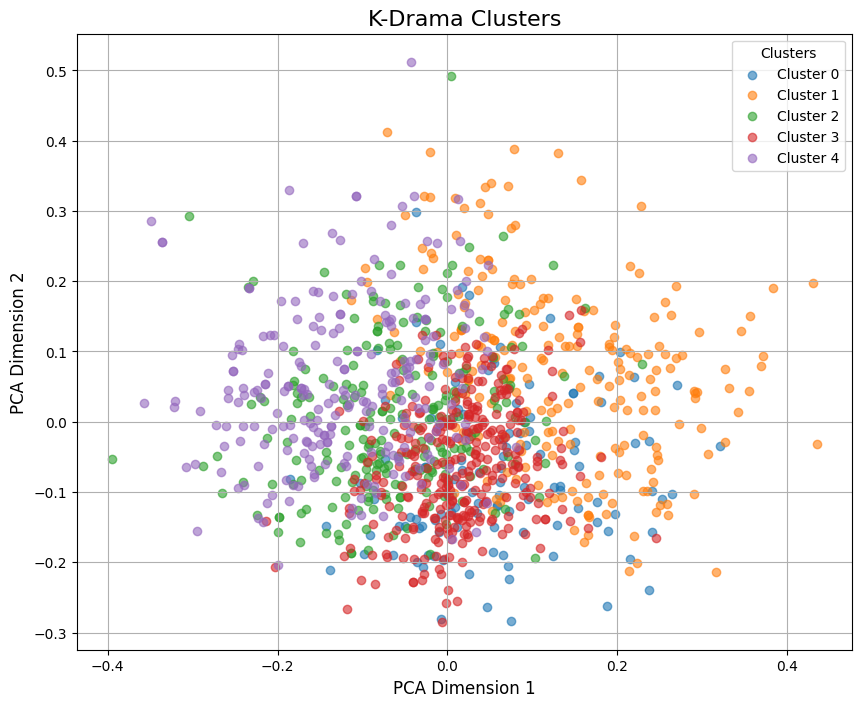

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load datasets
watched_kdramas = pd.read_csv("/content/watched_kdramas_complete_data.csv")
all_kdramas = pd.read_csv("/content/korean_dramas_complete_data.csv")

# Clean data: Handle missing values
all_kdramas.dropna(subset=['Title', 'Genre', 'Cast'], inplace=True)

# Normalize text fields for case-insensitivity
all_kdramas['Title'] = all_kdramas['Title'].str.lower()
all_kdramas['Genre'] = all_kdramas['Genre'].str.lower()

# Combine features for clustering
def combine_features(row):
    return f"{row['Genre']} {row['Cast']}"

all_kdramas['Combined'] = all_kdramas.apply(combine_features, axis=1)

# Vectorize Genres and Cast
tfidf = TfidfVectorizer(stop_words='english')
features = tfidf.fit_transform(all_kdramas['Combined'])

# Apply K-Means Clustering
n_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
all_kdramas['Cluster'] = kmeans.fit_predict(features)

# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features.toarray())

# Add reduced dimensions to the DataFrame for plotting
all_kdramas['PCA1'] = reduced_features[:, 0]
all_kdramas['PCA2'] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    clustered_data = all_kdramas[all_kdramas['Cluster'] == cluster]
    plt.scatter(clustered_data['PCA1'], clustered_data['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Drama Clusters', fontsize=16)
plt.xlabel('PCA Dimension 1', fontsize=12)
plt.ylabel('PCA Dimension 2', fontsize=12)
plt.legend(title="Clusters", fontsize=10)
plt.grid(True)
plt.show()


In [ ]:
# Vectorize Genres and Cast
tfidf = TfidfVectorizer(stop_words='english')
features = tfidf.fit_transform(all_kdramas['Combined'])  # Combined = Genre + Cast

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust n_clusters based on data size
all_kdramas['Cluster'] = kmeans.fit_predict(features)

def recommend_from_cluster(watched_titles):
    # Find the cluster(s) of the watched dramas
    watched_clusters = all_kdramas[all_kdramas['Title'].isin(watched_titles)]['Cluster'].unique()

    # Recommend dramas from the same clusters
    recommendations = all_kdramas[all_kdramas['Cluster'].isin(watched_clusters) &
                                   ~all_kdramas['Title'].isin(watched_titles)]['Title']
    return recommendations.head(10).tolist()

# Example Usage
watched_titles = ['drama a', 'drama b']  # Replace with actual watched dramas
print("Recommended K-Dramas from Clustering:")
print(recommend_from_cluster(watched_titles))

Recommended K-Dramas from Clustering:
[]


Sample Titles in all_kdramas:
                  Title  Cluster
0    100 days my prince        3
1      12 signs of love        1
2      12 years promise        2
3              18 again        0
5  365: repeat the year        0

Watched Titles (processed): ['drama a', 'drama b']

No matches found for the watched titles in all_kdramas.

Recommended K-Dramas from Clustering:
['No matching dramas found in clusters.']


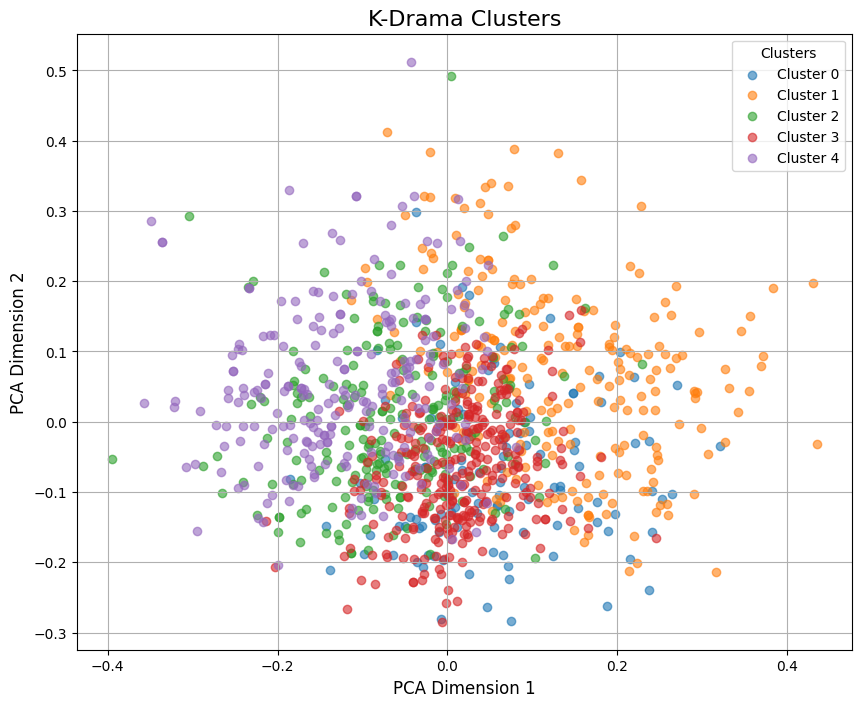

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load datasets
watched_kdramas = pd.read_csv("/content/watched_kdramas_complete_data.csv")
all_kdramas = pd.read_csv("/content/korean_dramas_complete_data.csv")

# Clean data: Handle missing values
all_kdramas.dropna(subset=['Title', 'Genre', 'Cast'], inplace=True)

# Normalize text fields for case-insensitivity
watched_kdramas['Title'] = watched_kdramas['Title'].str.lower()
all_kdramas['Title'] = all_kdramas['Title'].str.lower()
all_kdramas['Genre'] = all_kdramas['Genre'].str.lower()

# Combine features for clustering
def combine_features(row):
    return f"{row['Genre']} {row['Cast']}"

all_kdramas['Combined'] = all_kdramas.apply(combine_features, axis=1)

# Vectorize Genres and Cast
tfidf = TfidfVectorizer(stop_words='english')
features = tfidf.fit_transform(all_kdramas['Combined'])

# Apply K-Means Clustering
n_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
all_kdramas['Cluster'] = kmeans.fit_predict(features)

# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features.toarray())

# Add reduced dimensions to the DataFrame for plotting
all_kdramas['PCA1'] = reduced_features[:, 0]
all_kdramas['PCA2'] = reduced_features[:, 1]

# Debugging Step: Print sample titles
print("Sample Titles in all_kdramas:")
print(all_kdramas[['Title', 'Cluster']].head())

# Recommendation function
def recommend_from_cluster(watched_titles):
    # Ensure titles are in lowercase for matching
    watched_titles = [title.lower() for title in watched_titles]

    # Debugging Step: Print watched titles
    print("\nWatched Titles (processed):", watched_titles)

    # Find the cluster(s) of the watched dramas
    matched_clusters = all_kdramas[all_kdramas['Title'].isin(watched_titles)]
    if matched_clusters.empty:
        print("\nNo matches found for the watched titles in all_kdramas.")
        return ["No matching dramas found in clusters."]

    watched_clusters = matched_clusters['Cluster'].unique()
    print("\nClusters for Watched Titles:", watched_clusters)  # Debugging output

    if len(watched_clusters) == 0:
        print("\nWatched titles do not belong to any cluster.")
        return ["No matching dramas found in clusters."]

    # Recommend dramas from the same clusters
    recommendations = all_kdramas[(all_kdramas['Cluster'].isin(watched_clusters)) &
                                   (~all_kdramas['Title'].isin(watched_titles))]['Title']
    if recommendations.empty:
        print("\nNo recommendations found in the same clusters.")
        return ["No recommendations available."]

    return recommendations.head(10).tolist()

# Example Usage
watched_titles = ['drama a', 'drama b']  # Replace with actual watched dramas
recommendations = recommend_from_cluster(watched_titles)

# Display Recommendations
print("\nRecommended K-Dramas from Clustering:")
print(recommendations)

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    clustered_data = all_kdramas[all_kdramas['Cluster'] == cluster]
    plt.scatter(clustered_data['PCA1'], clustered_data['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Drama Clusters', fontsize=16)
plt.xlabel('PCA Dimension 1', fontsize=12)
plt.ylabel('PCA Dimension 2', fontsize=12)
plt.legend(title="Clusters", fontsize=10)
plt.grid(True)
plt.show()
